In [14]:
library(tidyverse)
library(magrittr)
library(text2vec)
library(tokenizers)
library(glmnet)
library(doParallel)
library(tm)
library(caret)
library(utiml)
library(pROC)
registerDoParallel(4)
library(lda)

## Data import

In [2]:
data_set <- read.csv("DATA/train.csv")
targets <- c("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate")

In [3]:
print(dim(data_set))
#print(head(data_set))
print(names(data_set))

[1] 159571      8
[1] "id"            "comment_text"  "toxic"         "severe_toxic" 
[5] "obscene"       "threat"        "insult"        "identity_hate"


## Adding new feature to the data set

In [7]:
data <- data_set %>% 
  select(-one_of(targets)) %>% 
  mutate(length = str_length(comment_text), ncap = str_count(comment_text, "[A-Z]"), ncap_len = ncap / length, nexcl = str_count(comment_text, fixed("!")), nquest = str_count(comment_text, fixed("?")), npunct = str_count(comment_text, "[[:punct:]]"), nword = str_count(comment_text, "\\w+"), nsymb = str_count(comment_text, "&|@|#|\\$|%|\\*|\\^")) %>% 
  select(-id)

## Preprocessing and comments tokenization  

In [8]:
comment_tokens <- data %$%
  str_to_lower(comment_text) %>%
  str_replace_all("[^[:alpha:]]", " ") %>%
  str_replace_all("\\s+", " ") %>%
  gsub("\\b\\w{1}\\s","", .) %>% #Remove words with lengh less than 2
  itoken(tokenizer = tokenize_word_stems)

##  Token vectorization as vocabulary for document term matrix

In [9]:
vectorizer <- create_vocabulary(comment_tokens, ngram = c(1, 1), stopwords = stopwords("en")) %>%
  prune_vocabulary(term_count_min = 3, doc_proportion_max = 0.5, vocab_term_max = 4000) %>%
  vocab_vectorizer()

## TFIDF class and fit in the document term matrix of the tokens

In [16]:
m_tfidf <- TfIdf$new(norm = "l2", sublinear_tf = T)
tfidf <- create_dtm(comment_tokens, vectorizer) %>%
  weightTf()

In [19]:
lda(tfidf)

ERROR: Error in lda(tfidf): impossible de trouver la fonction "lda"


In [ ]:
print(names(data))

# Generate the final dataset

In [ ]:
finaldata <- data %>%
    select(-comment_text) %>%
    sparse.model.matrix(~ . - 1, .) %>%
    cbind(tfidf)

In [ ]:
set.seed(42)
smp_size <- floor(0.80 * nrow(data_set))
train_ind <- sample(seq_len(nrow(data_set)), size = smp_size)
test <- finaldata[-train_ind, ]
train <- finaldata[train_ind, ]

# Working on the Logistic regression

In [178]:
prediction <- select(data_set[-train_ind, ], -comment_text)
train_label <- select(data_set[train_ind, ], -comment_text)
test_label <- prediction

In [179]:
for (label in targets){
    y_train <- train_label[[label]]
    model <- cv.glmnet(train,  factor(y_train), family="binomial", nfolds = 4, parallel = T,  nlambda = 100, alpha=0)
    prediction[[label]] <- predict(model, test, type = "response", s = "lambda.min")
}

In [180]:
prediction[1:5,]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0000997932d777bf,0.0189705568,0.0019188034,0.0047913665,0.0007309999,0.0037624869,0.0019278840
5,0001d958c54c6e35,0.0286691487,0.0009923556,0.0323233664,0.0004283634,0.0255175482,0.0040011252
7,0002bcb3da6cb337,0.9965078771,0.0758724728,0.9635744116,0.0022519545,0.5945125170,0.0099592776
11,0005300084f90edc,0.0002839812,0.0004026656,0.0009164614,0.0001453301,0.0003700149,0.0002089342
15,00070ef96486d6f9,0.0755905024,0.0018826387,0.0129517935,0.0008172589,0.0129216651,0.0050152329


In [181]:
thresh = 0.5
ss2 <- sweep(as.matrix(prediction[,-1]),MARGIN=2,STATS=thresh,
             FUN=function(x,y) ifelse(x<y,0,1))

In [182]:
prediction <- data.frame(id=prediction$id,ss2)

In [183]:
prediction[1:5,]
test_label[1:5,]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0000997932d777bf,0,0,0,0,0,0
5,0001d958c54c6e35,0,0,0,0,0,0
7,0002bcb3da6cb337,1,0,1,0,1,0
11,0005300084f90edc,0,0,0,0,0,0
15,00070ef96486d6f9,0,0,0,0,0,0


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,0000997932d777bf,0,0,0,0,0,0
5,0001d958c54c6e35,0,0,0,0,0,0
7,0002bcb3da6cb337,1,1,1,0,1,0
11,0005300084f90edc,0,0,0,0,0,0
15,00070ef96486d6f9,0,0,0,0,0,0


In [184]:
prediction_w_id <- select(prediction, -id)
test_label_w_id <- select(test_label, -id)



 toxic 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 28613   279
         1  1100  1923
                                         
               Accuracy : 0.9568         
                 95% CI : (0.9545, 0.959)
    No Information Rate : 0.931          
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.7132         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.87330        
            Specificity : 0.96298        
         Pos Pred Value : 0.63612        
         Neg Pred Value : 0.99034        
             Prevalence : 0.06900        
         Detection Rate : 0.06025        
   Detection Prevalence : 0.09472        
      Balanced Accuracy : 0.91814        
                                         
       'Positive' Class : 1              
                                         
Area under the curve: 0.813

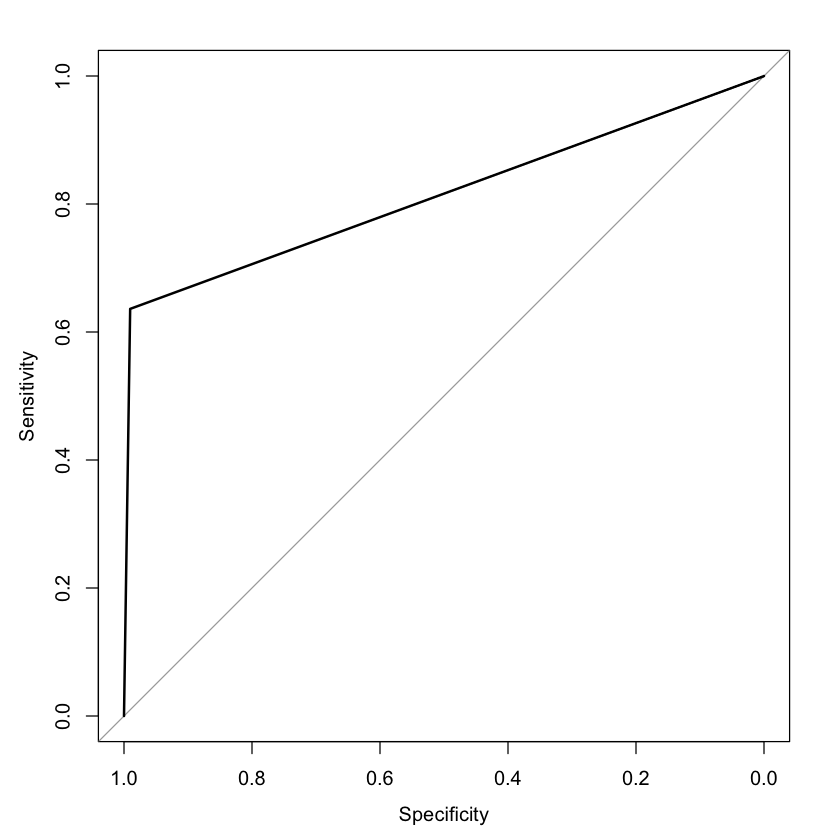

Area under the curve: 0.6273


 obscene 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30142   129
         1   585  1059
                                          
               Accuracy : 0.9776          
                 95% CI : (0.9759, 0.9792)
    No Information Rate : 0.9628          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7365          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.89141         
            Specificity : 0.98096         
         Pos Pred Value : 0.64416         
         Neg Pred Value : 0.99574         
             Prevalence : 0.03722         
         Detection Rate : 0.03318         
   Detection Prevalence : 0.05151         
      Balanced Accuracy : 0.93619         
                                          
       'Positive' Class : 1               
                   

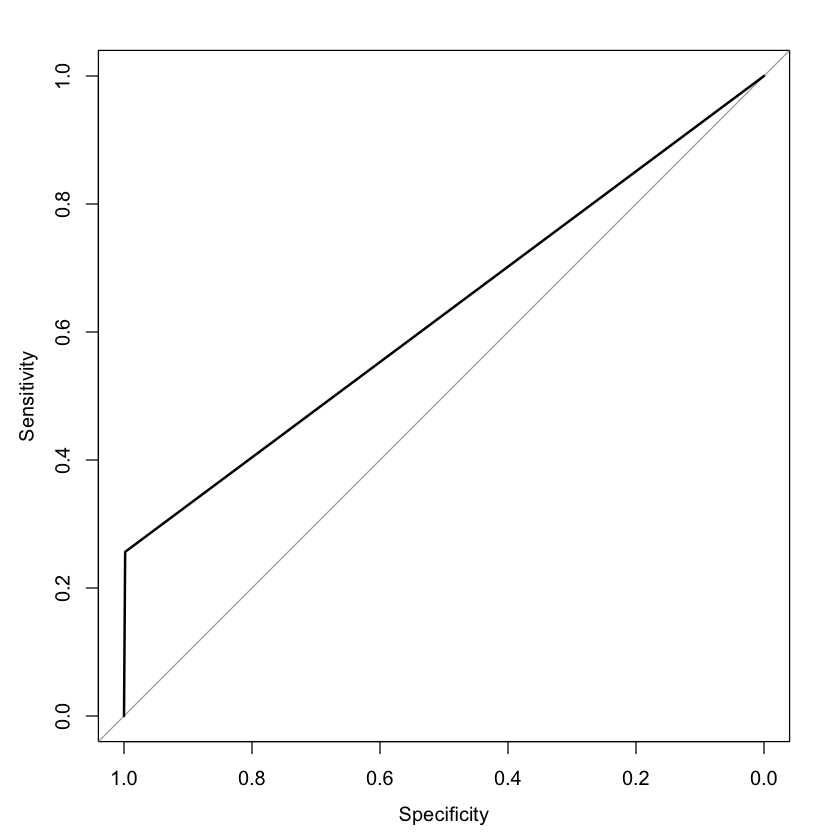

Area under the curve: 0.8199


 threat 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 31803    15
         1    81    16
                                          
               Accuracy : 0.997           
                 95% CI : (0.9963, 0.9976)
    No Information Rate : 0.999           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2489          
 Mcnemar's Test P-Value : 3.266e-11       
                                          
            Sensitivity : 0.5161290       
            Specificity : 0.9974595       
         Pos Pred Value : 0.1649485       
         Neg Pred Value : 0.9995286       
             Prevalence : 0.0009713       
         Detection Rate : 0.0005013       
   Detection Prevalence : 0.0030393       
      Balanced Accuracy : 0.7567943       
                                          
       'Positive' Class : 1               
                    

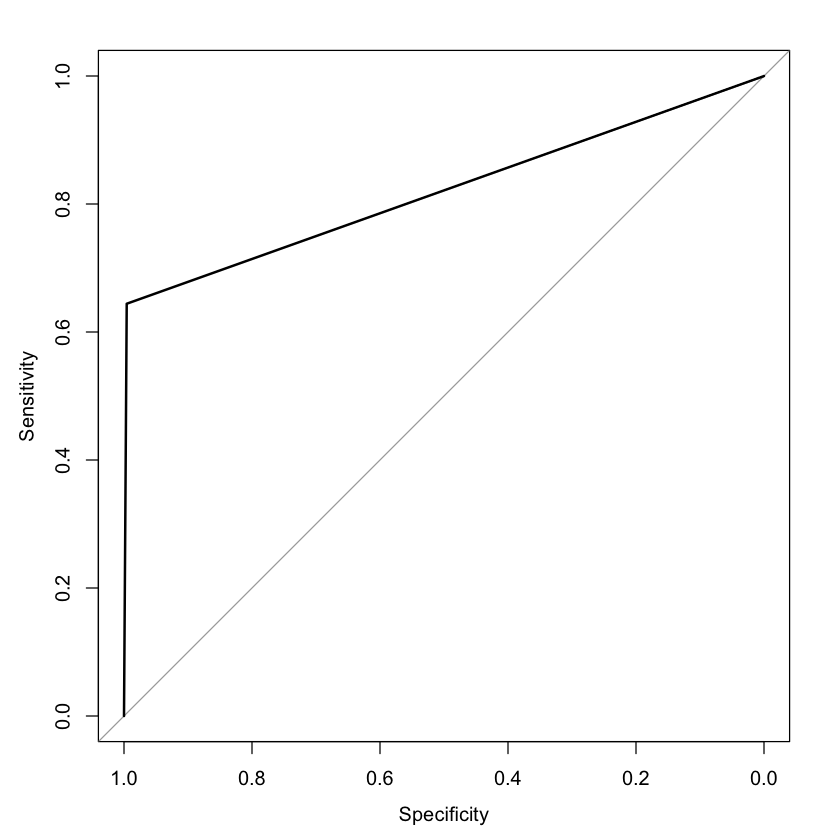

Area under the curve: 0.5822


 insult 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 30213   209
         1   700   793
                                          
               Accuracy : 0.9715          
                 95% CI : (0.9696, 0.9733)
    No Information Rate : 0.9686          
    P-Value [Acc > NIR] : 0.001306        
                                          
                  Kappa : 0.6214          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.79142         
            Specificity : 0.97736         
         Pos Pred Value : 0.53115         
         Neg Pred Value : 0.99313         
             Prevalence : 0.03140         
         Detection Rate : 0.02485         
   Detection Prevalence : 0.04678         
      Balanced Accuracy : 0.88439         
                                          
       'Positive' Class : 1               
                    

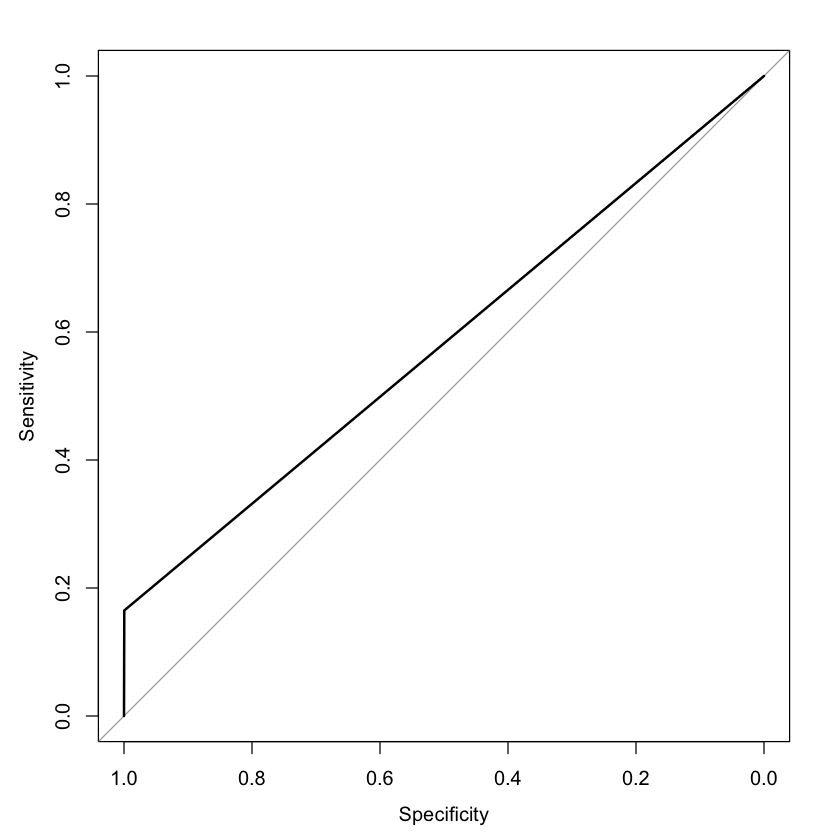

Area under the curve: 0.7621


 identity_hate 

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 31641    31
         1   180    63
                                          
               Accuracy : 0.9934          
                 95% CI : (0.9924, 0.9942)
    No Information Rate : 0.9971          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3712          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.670213        
            Specificity : 0.994343        
         Pos Pred Value : 0.259259        
         Neg Pred Value : 0.999021        
             Prevalence : 0.002945        
         Detection Rate : 0.001974        
   Detection Prevalence : 0.007614        
      Balanced Accuracy : 0.832278        
                                          
       'Positive' Class : 1               
             

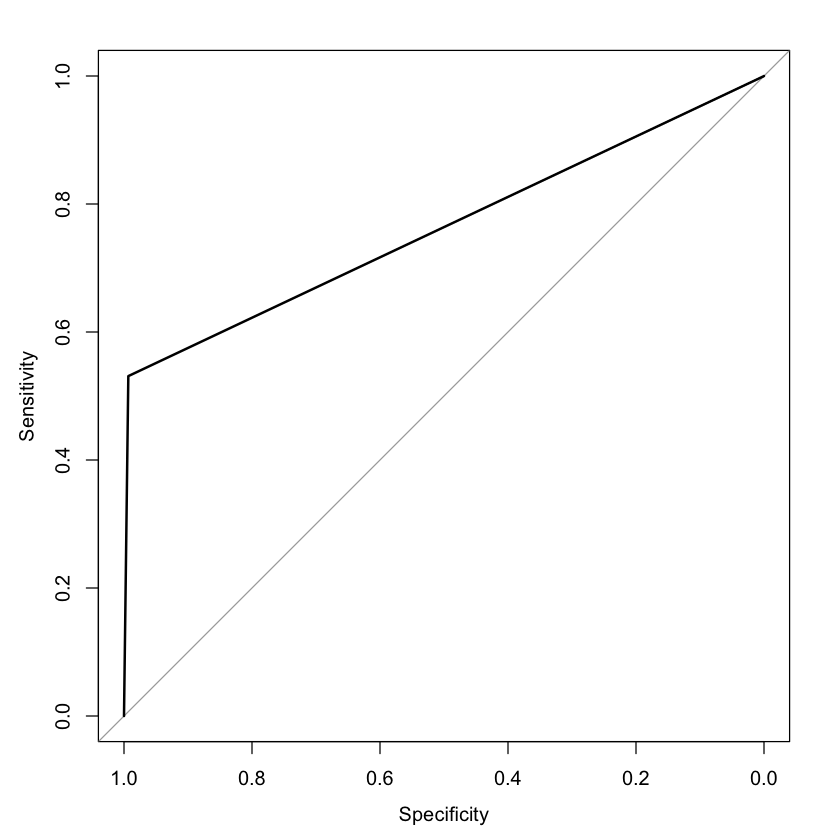

Area under the curve: 0.6291


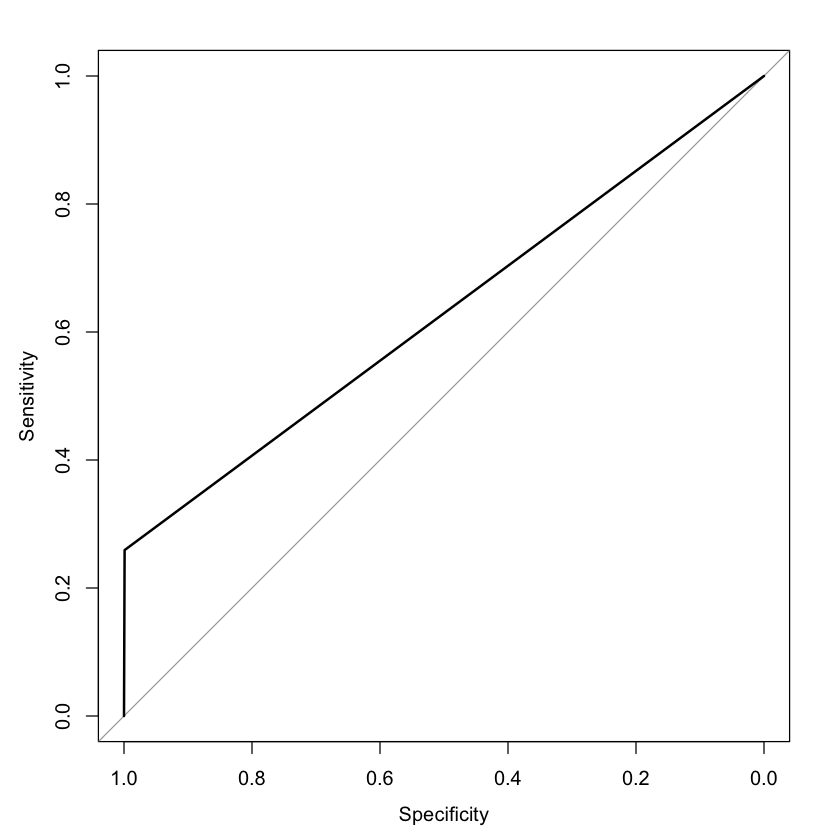

In [199]:
for (label in targets) {
    cat("\n\n", label, "\n\n")
    print(confusionMatrix(test_label_w_id[[label]], prediction_w_id[[label]], positive="1"))
    plot(roc(test_label_w_id[[label]], prediction_w_id[[label]], col="yellow", lwd=3))
    print(auc(test_label_w_id[[label]], prediction_w_id[[label]]))
}

### The training model perform a pretty good accuracy but has a low F1 for most of the labels due to the fact that some labels have a small number of observation. For instance threat label has 31 observations which is really small compare to the 159571 total observation. It will be interesting to add more observations relative to this label to have good recall for our model. At the end, we can see that the model is really good for classifying non toxic comments over the internet.